In [1]:
%load_ext autoreload
%autoreload 2

import fastai
from fastai import *

from fastai.collab import *

In [2]:
fastai.__version__

'1.0.58.dev0'

In [3]:
lesson_dir_path = Path('lesson4-collab')
data_dir_path = lesson_dir_path/'ml-100k'

In [4]:
df_ratings = pd.read_csv(data_dir_path/'u.data', delimiter='\t', header=None, names=['userId','movieId','rating','timestamp'])
df_ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
df_movies = pd.read_csv(data_dir_path/'u.item',  delimiter='|', encoding='latin-1', header=None, names=['movieId', 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
df_movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
df_rating_movie = df_ratings.merge(df_movies[['movieId', 'title']], on='movieId')
df_rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [7]:
data = CollabDataBunch.from_df(df_rating_movie, seed=1, valid_pct=0.2, item_name='title')
data.show_batch()

userId,title,target
328,Beyond Rangoon (1995),3.0
493,What's Eating Gilbert Grape (1993),4.0
522,Supercop (1992),4.0
271,"Manchurian Candidate, The (1962)",4.0
184,Basquiat (1996),4.0


In [8]:
y_range = [0,5.5]
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


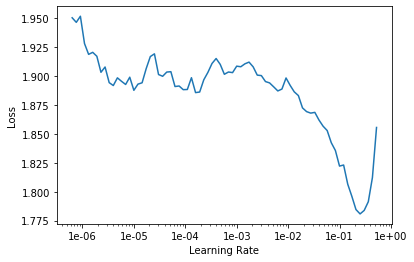

In [9]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [10]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.971300,0.937436,00:03
1,0.877595,0.858417,00:03
2,0.769388,0.817212,00:03
3,0.651918,0.797924,00:03
4,0.554148,0.798199,00:03


In [11]:
learn.save('base')

## Analysis

In [12]:
learn.load('base');

In [13]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1643, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1643, 1)
)

In [14]:
g = df_rating_movie.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

## Movie Bias

In [15]:
biases = learn.bias(top_movies, is_item=True)
biases.shape

torch.Size([1000])

In [16]:
df_mean = df_rating_movie.groupby('title')['rating'].mean()
df_mean.head()

title
'Til There Was You (1997)    2.333333
1-900 (1994)                 2.600000
101 Dalmatians (1996)        2.908257
12 Angry Men (1957)          4.344000
187 (1997)                   3.024390
Name: rating, dtype: float64

In [17]:
df_bias = pd.DataFrame({'title': top_movies,
                        'bias': biases})
df_bias.head()

,title,bias
0,Star Wars (1977),0.557141
1,Contact (1997),0.416143
2,Fargo (1996),0.358310
3,Return of the Jedi (1983),0.431504
4,Liar Liar (1997),0.026747


In [18]:
df_bias_mean = df_bias.merge(df_mean, on='title')

In [19]:
df_bias_mean.sort_values(by='bias', ascending=True).head()

,title,bias,rating
933,Children of the Corn: The Gathering (1996),-0.417153,1.315789
830,Free Willy 3: The Rescue (1997),-0.306365,1.740741
910,Lawnmower Man 2: Beyond Cyberspace (1996),-0.290392,1.714286
659,Leave It to Beaver (1997),-0.277470,1.840909
864,Halloween: The Curse of Michael Myers (1995),-0.263183,2.200000


In [20]:
df_bias_mean.sort_values(by='bias', ascending=False).head()

,title,bias,rating
0,Star Wars (1977),0.557141,4.358491
21,Titanic (1997),0.553600,4.245714
35,Schindler's List (1993),0.550650,4.466443
14,"Silence of the Lambs, The (1991)",0.523356,4.289744
38,L.A. Confidential (1997),0.522052,4.161616


## Movie weights

In [21]:
weights = learn.weight(top_movies, is_item=True)
weights.shape

torch.Size([1000, 40])

In [22]:
weights_pca = weights.pca(3)
weights_pca.shape

torch.Size([1000, 3])

In [23]:
df_weight = pd.DataFrame({'title': top_movies,
                          'w0': weights_pca[:,0],
                          'w1': weights_pca[:,1],
                          'w2': weights_pca[:,2]})

In [24]:
df_weight_mean = df_weight.merge(df_mean, on='title')

In [25]:
df_weight_mean.sort_values(by='w0', ascending=True).head()

,title,w0,w1,w2,rating
237,Jungle2Jungle (1997),-1.266222,-0.100806,-0.055201,2.439394
931,Home Alone 3 (1997),-1.244544,0.160664,-0.158078,1.894737
466,McHale's Navy (1997),-1.201821,0.414995,0.000966,2.188406
933,Children of the Corn: The Gathering (1996),-1.192741,0.427705,0.337982,1.315789
939,D3: The Mighty Ducks (1996),-1.158928,-0.150375,0.085212,2.578947


In [26]:
df_weight_mean.sort_values(by='w0', ascending=False).head()

,title,w0,w1,w2,rating
212,Chinatown (1974),1.121232,0.266832,0.001492,4.136054
74,Casablanca (1942),1.097448,-0.283840,0.244966,4.456790
285,"Wrong Trousers, The (1993)",1.013133,-0.192320,-0.352264,4.466102
695,Some Folks Call It a Sling Blade (1993),1.012075,-0.365322,0.044061,4.292683
123,Dr. Strangelove or: How I Learned to Stop Worr...,0.993356,0.483946,0.269498,4.252577


In [27]:
df_weight_mean.sort_values(by='w1', ascending=True).head()

,title,w0,w1,w2,rating
37,Braveheart (1995),0.428879,-1.142492,-0.265132,4.151515
177,"American President, The (1995)",-0.208567,-1.101660,0.267647,3.628049
21,Titanic (1997),0.121823,-0.987626,-0.316697,4.245714
10,Raiders of the Lost Ark (1981),0.561517,-0.915228,-0.539349,4.252381
9,Independence Day (ID4) (1996),-0.446022,-0.915118,-0.470305,3.438228


In [28]:
df_weight_mean.sort_values(by='w1', ascending=False).head()

,title,w0,w1,w2,rating
885,Jude (1996),0.008404,0.988054,-0.018151,3.000000
262,Lost Highway (1997),0.048581,0.972850,-0.127712,3.136000
574,Serial Mom (1994),0.020803,0.904213,-0.002032,2.814815
754,Dead Man (1995),0.331902,0.850638,-0.224129,3.823529
845,Spice World (1997),-0.426744,0.844276,-0.313383,2.115385


In [29]:
df_weight_mean.sort_values(by='w2', ascending=True).head()

,title,w0,w1,w2,rating
32,"Terminator, The (1984)",0.156038,-0.345308,-1.080037,3.933555
194,Beavis and Butt-head Do America (1996),-0.422051,0.674381,-0.896275,2.788462
39,Terminator 2: Judgment Day (1991),0.074067,-0.716955,-0.840070,4.006780
121,"Fifth Element, The (1997)",-0.343604,0.155456,-0.809683,3.477157
0,Star Wars (1977),0.744143,-0.665170,-0.759388,4.358491


In [30]:
df_weight_mean.sort_values(by='w2', ascending=False).head()

,title,w0,w1,w2,rating
278,Cinema Paradiso (1988),0.831263,-0.228584,0.672318,4.173554
312,On Golden Pond (1981),0.367467,-0.214820,0.646557,3.556604
128,Sabrina (1995),-0.063099,-0.596982,0.640696,3.500000
522,Star Trek V: The Final Frontier (1989),-0.651486,0.075708,0.621407,2.396825
173,"Piano, The (1993)",0.381965,0.108816,0.606832,3.601190


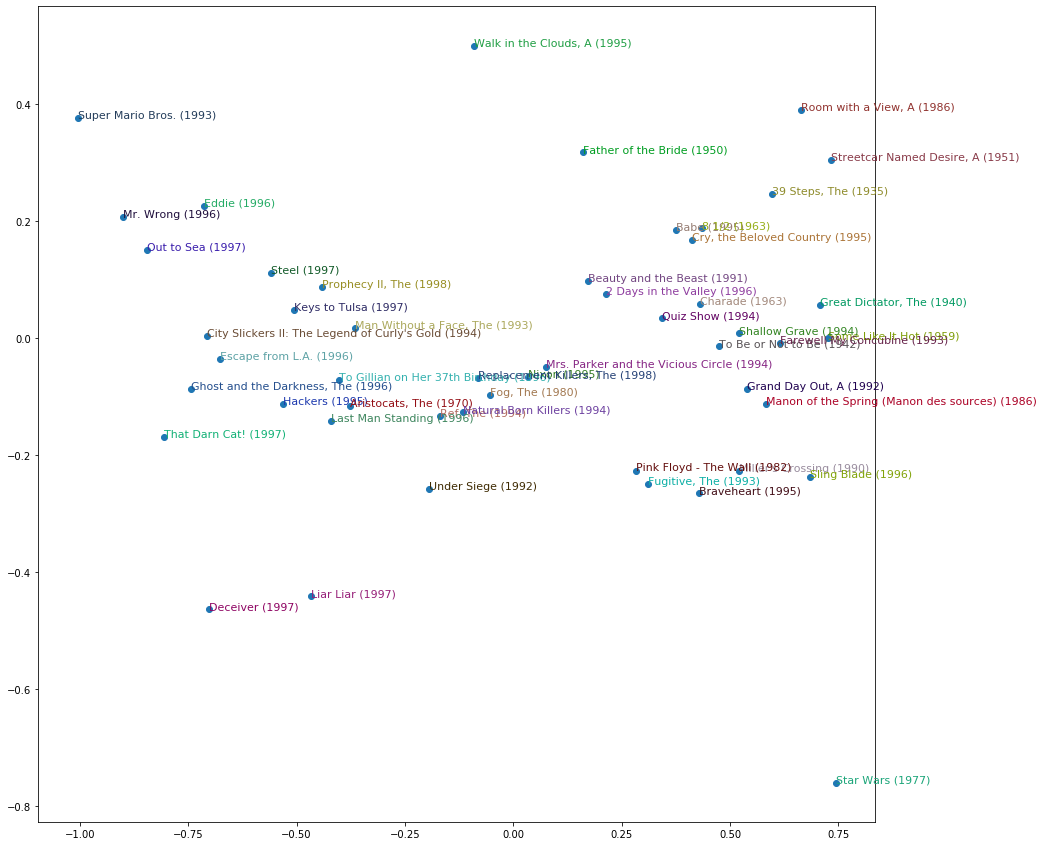

In [31]:
df_plot = df_weight_mean.sample(50)

idx = 100
plt.figure(figsize=(15,15))
plt.scatter(df_plot['w0'], df_plot['w2'])
for idx, row in df_plot.iterrows():
    plt.text(row['w0'], row['w2'], row['title'], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()